In [ ]:
from data_provider.data_factory import data_provider

  Median (sampled): 0.155589
  25th percentile: -0.973505
  75th percentile: 0.807485
  IQR: 1.780990

=== Target Features ===
  Total data points: 798,437,376
  Mean: 0.002055
  Std:  0.999511
  Min:  -2.707399
  Max:  10.050601
  [Sampling 1M points for histogram]
  Median (sampled): 0.157678
  25th percentile: -0.972029
  75th percentile: 0.809115
  IQR: 1.781144

Generating histograms...


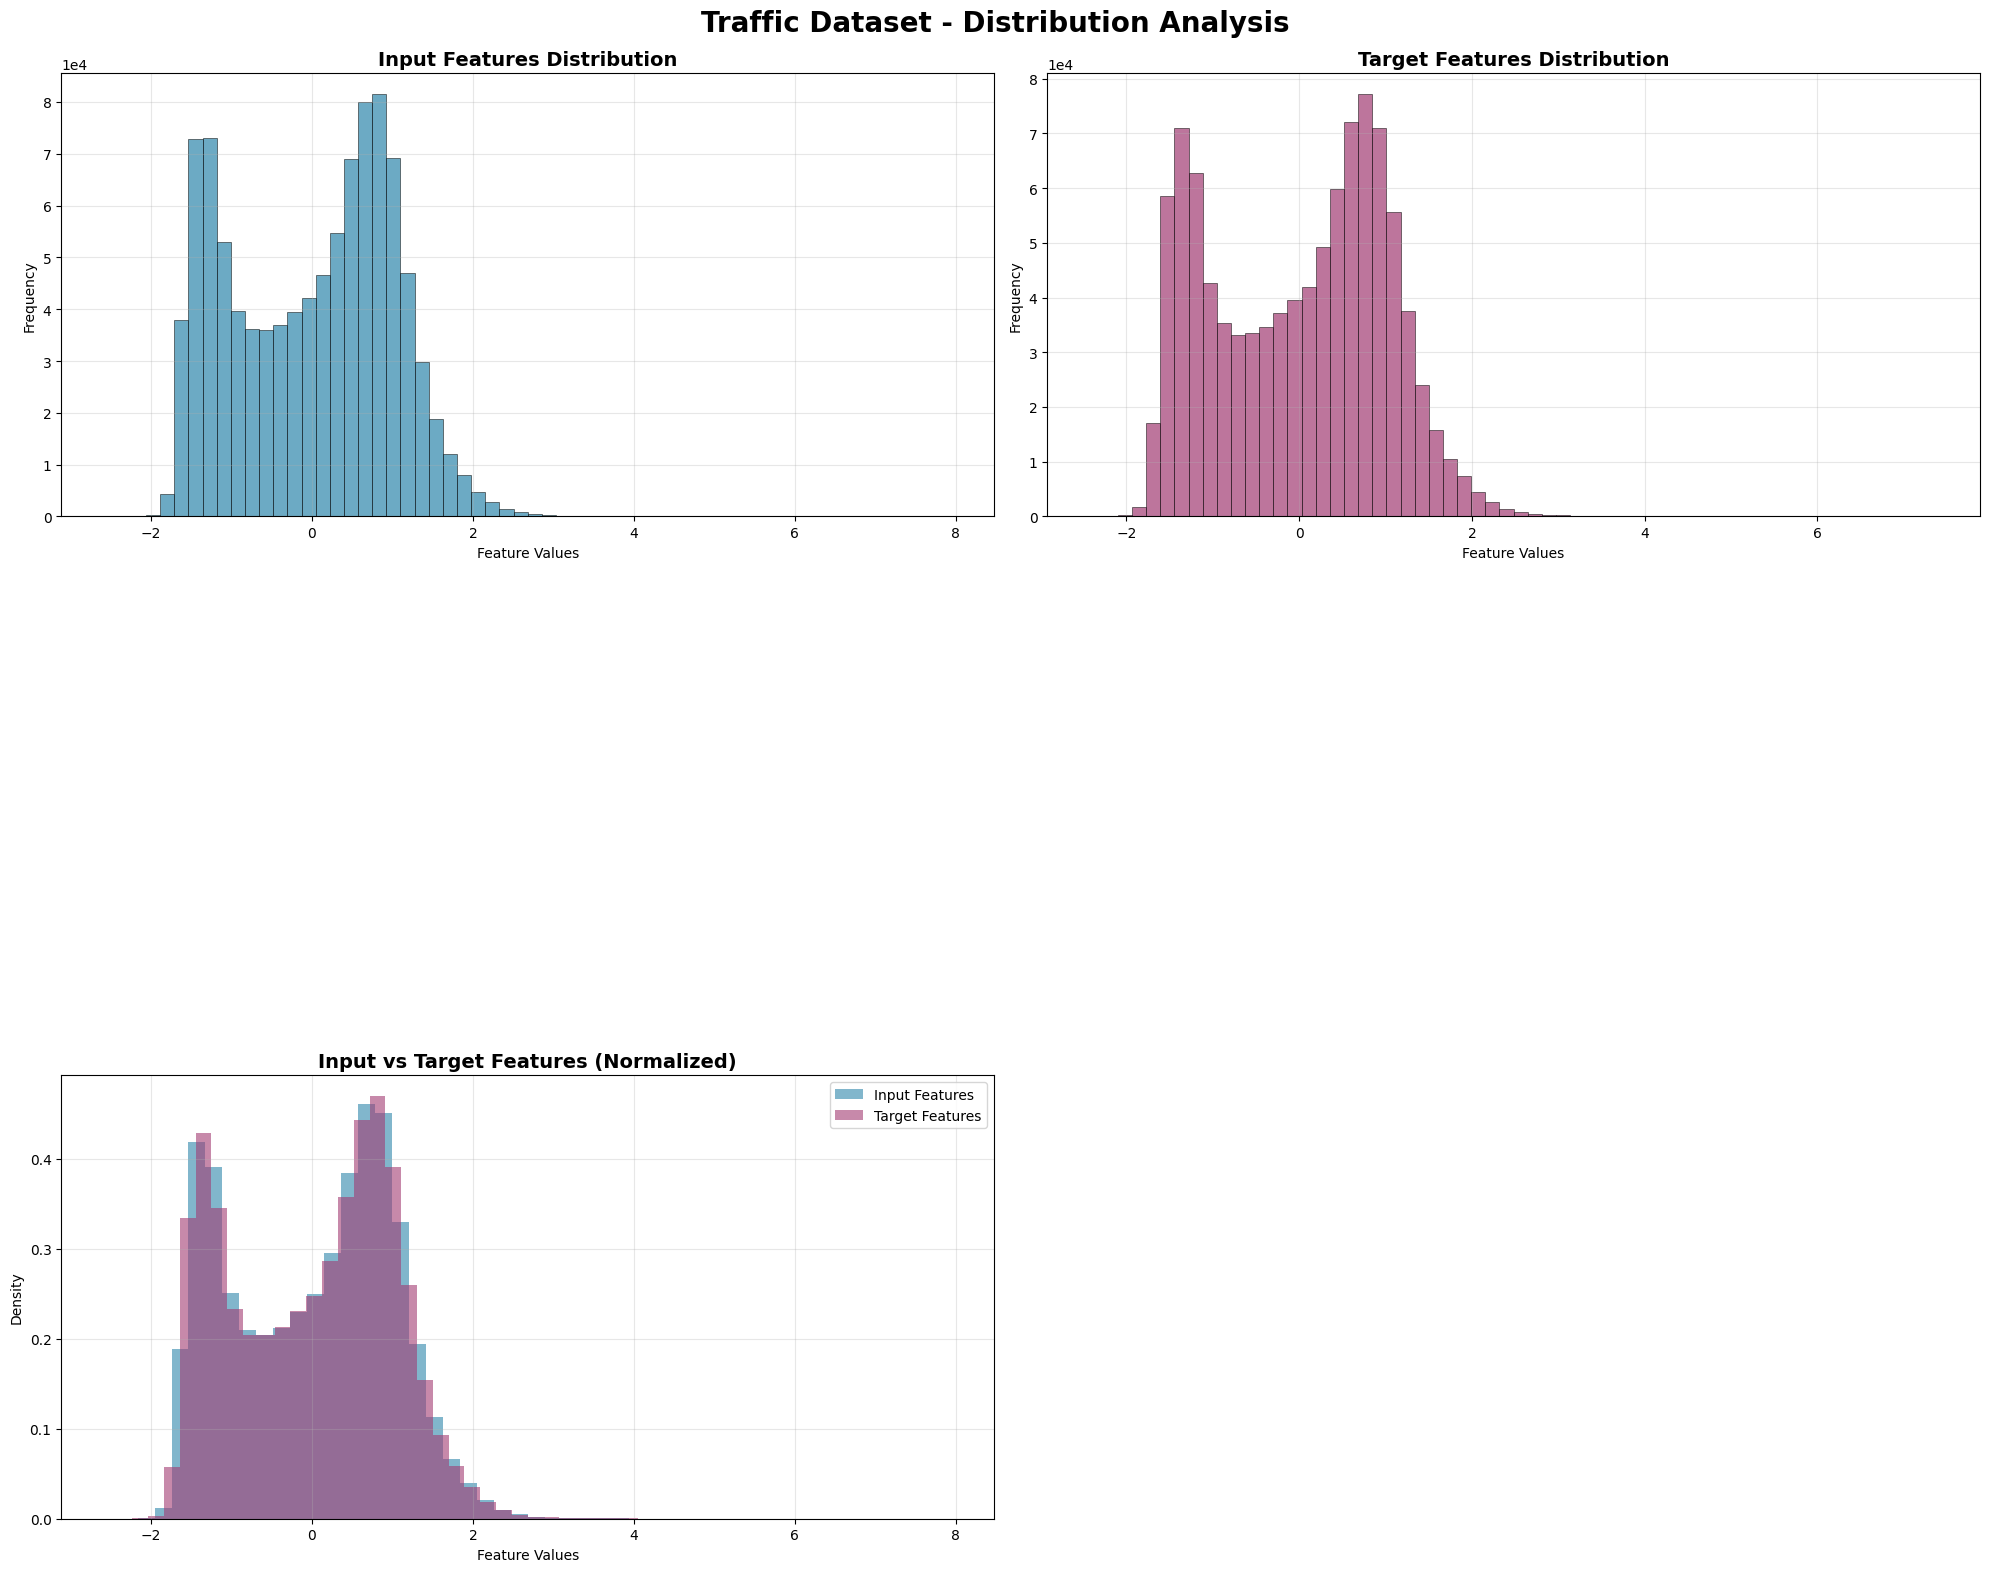


TRAFFIC DATASET INSIGHTS

Input Features:
  • Distribution shape: Approximately symmetric
  • Variability: High
  • Scale: 0.001 ± 1.000

Target Features:
  • Distribution shape: Approximately symmetric
  • Variability: High
  • Scale: 0.003 ± 1.000

Key Observations:
  • Input and target features are very similar
  • Feature values range from -2.587 to 7.949
  • Total data points analyzed: 1,000,000 (sampled)


In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import argparse
from data_provider.data_factory import data_provider

# Traffic dataset configuration
data = 'PEMS'
dataset_name = 'PEMS'
features = 'M'
seq_len = 96
label_len = 48
pred_len = 96
embed = 'timeF'
batch_size = 128
flag = 'train'

args = argparse.Namespace(
    data=data,
    root_path='dataset/PEMS/',
    data_path=f'PEMS03.npz',
    features=features,
    target='OT',
    freq='h' if 'h' in dataset_name else 't',
    seq_len=seq_len,
    label_len=label_len,
    pred_len=pred_len,
    embed=embed,
    batch_size=batch_size,
    num_workers=2
)

print("Loading Traffic dataset...")
dataset, loader = data_provider(args, flag=flag)

# Initialize accumulators
all_x = []
all_y = []
all_x_mark = []
all_y_mark = []

print("Collecting batches...")
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(loader):
    all_x.append(batch_x)
    all_y.append(batch_y)
    all_x_mark.append(batch_x_mark)
    all_y_mark.append(batch_y_mark)
    
    if i == 0:  # Print shapes for first batch
        print(f"Batch shapes:")
        print(f"  Input: {batch_x.shape}")
        print(f"  Target: {batch_y.shape}")
        print(f"  Input time: {batch_x_mark.shape}")
        print(f"  Target time: {batch_y_mark.shape}")

# Concatenate over batches
all_x = torch.cat(all_x, dim=0)
all_y = torch.cat(all_y, dim=0)
# all_x_mark = torch.cat(all_x_mark, dim=0)
# all_y_mark = torch.cat(all_y_mark, dim=0)

print(f"\nTotal dataset shapes:")
print(f"  Input features: {all_x.shape}")
print(f"  Target features: {all_y.shape}")
# print(f"  Input time: {all_x_mark.shape}")
# print(f"  Target time: {all_y_mark.shape}")

# Flatten ALL dimensions to get single distributions
x_all_flat = all_x.flatten()
y_all_flat = all_y.flatten()
# x_mark_all_flat = all_x_mark.flatten()
# y_mark_all_flat = all_y_mark.flatten()

def get_summary_stats_with_sample(tensor, name):
    """Get summary stats and return sample for histogram"""
    print(f"\n=== {name} ===")
    print(f"  Total data points: {tensor.numel():,}")
    print(f"  Mean: {torch.mean(tensor).item():.6f}")
    print(f"  Std:  {torch.std(tensor).item():.6f}")
    print(f"  Min:  {torch.min(tensor).item():.6f}")
    print(f"  Max:  {torch.max(tensor).item():.6f}")
    
    # For large tensors, sample for histogram
    if tensor.numel() > 1_000_000:
        print("  [Sampling 1M points for histogram]")
        sample_size = 1_000_000
        indices = torch.randperm(tensor.numel())[:sample_size]
        sample_tensor = tensor[indices]
        
        # Get percentiles from sample
        median = torch.median(sample_tensor).item()
        q25 = torch.quantile(sample_tensor, 0.25).item()
        q75 = torch.quantile(sample_tensor, 0.75).item()
        
        print(f"  Median (sampled): {median:.6f}")
        print(f"  25th percentile: {q25:.6f}")
        print(f"  75th percentile: {q75:.6f}")
        print(f"  IQR: {q75-q25:.6f}")
        
        return sample_tensor.numpy()
    else:
        # Use full tensor for smaller datasets
        median = torch.median(tensor).item()
        q25 = torch.quantile(tensor, 0.25).item()
        q75 = torch.quantile(tensor, 0.75).item()
        
        print(f"  Median: {median:.6f}")
        print(f"  25th percentile: {q25:.6f}")
        print(f"  75th percentile: {q75:.6f}")
        print(f"  IQR: {q75-q25:.6f}")
        
        return tensor.numpy()

# Get statistics and data for histograms
print("\nComputing statistics...")
x_data = get_summary_stats_with_sample(x_all_flat, "Input Features")
y_data = get_summary_stats_with_sample(y_all_flat, "Target Features")
# x_mark_data = get_summary_stats_with_sample(x_mark_all_flat, "Input Time Features")
# y_mark_data = get_summary_stats_with_sample(y_mark_all_flat, "Target Time Features")

# Create comprehensive histogram visualization
print("\nGenerating histograms...")

# Set up the figure with subplots
fig = plt.figure(figsize=(20, 16))
fig.suptitle('Traffic Dataset - Distribution Analysis', fontsize=20, fontweight='bold', y=0.98)

# Define colors for different data types
colors = {
    'input': '#2E86AB',      # Blue
    'target': '#A23B72',     # Red-purple
    'time_input': '#F18F01',  # Orange
    'time_target': '#C73E1D'  # Red
}

# 1. Main feature distributions (top row)
ax1 = plt.subplot(3, 2, 1)
plt.hist(x_data, bins=60, alpha=0.7, color=colors['input'], edgecolor='black', linewidth=0.5)
plt.title('Input Features Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Feature Values')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

ax2 = plt.subplot(3, 2, 2)
plt.hist(y_data, bins=60, alpha=0.7, color=colors['target'], edgecolor='black', linewidth=0.5)
plt.title('Target Features Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Feature Values')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# # 2. Time feature distributions (middle row)
# ax3 = plt.subplot(3, 2, 3)
# plt.hist(x_mark_data, bins=30, alpha=0.7, color=colors['time_input'], edgecolor='black', linewidth=0.5)
# plt.title('Input Time Features Distribution', fontsize=14, fontweight='bold')
# plt.xlabel('Time Feature Values')
# plt.ylabel('Frequency')
# plt.grid(True, alpha=0.3)
# plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# ax4 = plt.subplot(3, 2, 4)
# plt.hist(y_mark_data, bins=30, alpha=0.7, color=colors['time_target'], edgecolor='black', linewidth=0.5)
# plt.title('Target Time Features Distribution', fontsize=14, fontweight='bold')
# plt.xlabel('Time Feature Values')
# plt.ylabel('Frequency')
# plt.grid(True, alpha=0.3)
# plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# 3. Overlay comparison (bottom row)
ax5 = plt.subplot(3, 2, 5)
plt.hist(x_data, bins=50, alpha=0.6, color=colors['input'], label='Input Features', density=True)
plt.hist(y_data, bins=50, alpha=0.6, color=colors['target'], label='Target Features', density=True)
plt.title('Input vs Target Features (Normalized)', fontsize=14, fontweight='bold')
plt.xlabel('Feature Values')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

# ax6 = plt.subplot(3, 2, 6)
# plt.hist(x_mark_data, bins=25, alpha=0.6, color=colors['time_input'], label='Input Time', density=True)
# plt.hist(y_mark_data, bins=25, alpha=0.6, color=colors['time_target'], label='Target Time', density=True)
# plt.title('Input vs Target Time Features (Normalized)', fontsize=14, fontweight='bold')
# plt.xlabel('Time Feature Values')
# plt.ylabel('Density')
# plt.legend()
# plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()

# Print summary insights
print("\n" + "="*60)
print("TRAFFIC DATASET INSIGHTS")
print("="*60)

def print_insights(data, name):
    mean_val = np.mean(data)
    std_val = np.std(data)
    skewness = np.mean(((data - mean_val) / std_val) ** 3) if std_val > 0 else 0
    
    print(f"\n{name}:")
    print(f"  • Distribution shape: {'Right-skewed' if skewness > 0.5 else 'Left-skewed' if skewness < -0.5 else 'Approximately symmetric'}")
    print(f"  • Variability: {'High' if std_val > abs(mean_val) else 'Moderate' if std_val > 0.5 * abs(mean_val) else 'Low'}")
    print(f"  • Scale: {mean_val:.3f} ± {std_val:.3f}")

print_insights(x_data, "Input Features")
print_insights(y_data, "Target Features")
# print_insights(x_mark_data, "Input Time Features")
# print_insights(y_mark_data, "Target Time Features")

print(f"\nKey Observations:")
print(f"  • Input and target features are {'very similar' if np.abs(np.mean(x_data) - np.mean(y_data)) < 0.1 else 'different'}")
# print(f"  • Time features range from {np.min(x_mark_data):.3f} to {np.max(x_mark_data):.3f}")
print(f"  • Feature values range from {np.min(x_data):.3f} to {np.max(x_data):.3f}")
print(f"  • Total data points analyzed: {len(x_data):,} (sampled)" if len(x_data) == 1_000_000 else f"  • Total data points analyzed: {len(x_data):,} (full dataset)")

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import argparse
from data_provider.data_factory import data_provider

# Dataset configuration - easily changeable
data = 'custom'
dataset_name = 'ETTh1'  # Change this to any small dataset: ETTh1, ETTh2, ETTm1, ETTm2, ILI
features = 'M'
seq_len = 96
label_len = 48
pred_len = 96
embed = 'timeF'
batch_size = 32
flag = 'train'

args = argparse.Namespace(
    data=data,
    root_path='dataset/',
    data_path=f'{dataset_name}.csv',
    features=features,
    target='OT',
    freq='h' if 'h' in dataset_name else 't',
    seq_len=seq_len,
    label_len=label_len,
    pred_len=pred_len,
    embed=embed,
    batch_size=batch_size,
    num_workers=2
)

print(f"Loading {dataset_name} dataset...")
dataset, loader = data_provider(args, flag=flag)

# Initialize accumulators
all_x = []
all_y = []
all_x_mark = []
all_y_mark = []

print("Collecting all batches (no sampling)...")
batch_count = 0
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(loader):
    all_x.append(batch_x)
    all_y.append(batch_y)
    all_x_mark.append(batch_x_mark)
    all_y_mark.append(batch_y_mark)
    batch_count += 1
    
    if i == 0:  # Print shapes for first batch
        print(f"Batch shapes:")
        print(f"  Input: {batch_x.shape}")
        print(f"  Target: {batch_y.shape}")
        print(f"  Input time: {batch_x_mark.shape}")
        print(f"  Target time: {batch_y_mark.shape}")

print(f"Processed {batch_count} batches")

# Concatenate over batches
all_x = torch.cat(all_x, dim=0)
all_y = torch.cat(all_y, dim=0)
all_x_mark = torch.cat(all_x_mark, dim=0)
all_y_mark = torch.cat(all_y_mark, dim=0)

print(f"\nTotal dataset shapes:")
print(f"  Input features: {all_x.shape}")
print(f"  Target features: {all_y.shape}")
print(f"  Input time: {all_x_mark.shape}")
print(f"  Target time: {all_y_mark.shape}")

# Flatten ALL dimensions to get single distributions (FULL DATA - NO SAMPLING)
x_all_flat = all_x.flatten()
y_all_flat = all_y.flatten()
x_mark_all_flat = all_x_mark.flatten()
y_mark_all_flat = all_y_mark.flatten()

def get_full_stats(tensor, name):
    """Get complete statistics on full dataset (no sampling)"""
    print(f"\n=== {name} (FULL DATASET) ===")
    print(f"  Total data points: {tensor.numel():,}")
    print(f"  Mean: {torch.mean(tensor).item():.6f}")
    print(f"  Std:  {torch.std(tensor).item():.6f}")
    print(f"  Min:  {torch.min(tensor).item():.6f}")
    print(f"  Max:  {torch.max(tensor).item():.6f}")
    
    # Calculate exact percentiles on full data
    median = torch.median(tensor).item()
    q25 = torch.quantile(tensor, 0.25).item()
    q75 = torch.quantile(tensor, 0.75).item()
    q10 = torch.quantile(tensor, 0.10).item()
    q90 = torch.quantile(tensor, 0.90).item()
    
    print(f"  10th percentile: {q10:.6f}")
    print(f"  25th percentile: {q25:.6f}")
    print(f"  Median (50th): {median:.6f}")
    print(f"  75th percentile: {q75:.6f}")
    print(f"  90th percentile: {q90:.6f}")
    print(f"  IQR (Q3-Q1): {q75-q25:.6f}")
    
    # Outlier analysis using exact values
    iqr = q75 - q25
    lower_bound = q25 - 1.5 * iqr
    upper_bound = q75 + 1.5 * iqr
    outliers = ((tensor < lower_bound) | (tensor > upper_bound)).sum().item()
    print(f"  Outliers (beyond 1.5*IQR): {outliers:,} ({100*outliers/tensor.numel():.2f}%)")
    
    # Additional statistics
    range_val = torch.max(tensor).item() - torch.min(tensor).item()
    cv = torch.std(tensor).item() / abs(torch.mean(tensor).item()) if torch.mean(tensor).item() != 0 else float('inf')
    print(f"  Range: {range_val:.6f}")
    print(f"  Coefficient of Variation: {cv:.4f}")
    
    return tensor.numpy()

# Get complete statistics and data for histograms
print("\nComputing complete statistics on full dataset...")
x_data = get_full_stats(x_all_flat, "Input Features")
y_data = get_full_stats(y_all_flat, "Target Features")
x_mark_data = get_full_stats(x_mark_all_flat, "Input Time Features")
y_mark_data = get_full_stats(y_mark_all_flat, "Target Time Features")

# Create enhanced histogram visualization
print("\nGenerating detailed histograms...")

# Set up the figure with more subplots for detailed analysis
fig = plt.figure(figsize=(24, 20))
fig.suptitle(f'{dataset_name} Dataset - Complete Distribution Analysis (Full Data)', 
             fontsize=20, fontweight='bold', y=0.98)

# Define colors
colors = {
    'input': '#1f77b4',      # Blue
    'target': '#ff7f0e',     # Orange  
    'time_input': '#2ca02c', # Green
    'time_target': '#d62728'  # Red
}

# 1. Main feature distributions with more details (top row)
ax1 = plt.subplot(4, 3, 1)
n1, bins1, patches1 = plt.hist(x_data, bins=80, alpha=0.7, color=colors['input'], 
                               edgecolor='black', linewidth=0.3)
plt.title('Input Features Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Feature Values')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
# Add mean and median lines
plt.axvline(np.mean(x_data), color='red', linestyle='--', alpha=0.8, label=f'Mean: {np.mean(x_data):.3f}')
plt.axvline(np.median(x_data), color='green', linestyle='--', alpha=0.8, label=f'Median: {np.median(x_data):.3f}')
plt.legend()

ax2 = plt.subplot(4, 3, 2)
n2, bins2, patches2 = plt.hist(y_data, bins=80, alpha=0.7, color=colors['target'], 
                               edgecolor='black', linewidth=0.3)
plt.title('Target Features Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Feature Values')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.axvline(np.mean(y_data), color='red', linestyle='--', alpha=0.8, label=f'Mean: {np.mean(y_data):.3f}')
plt.axvline(np.median(y_data), color='green', linestyle='--', alpha=0.8, label=f'Median: {np.median(y_data):.3f}')
plt.legend()

# 2. Box plots for quartile visualization
ax3 = plt.subplot(4, 3, 3)
box_data = [x_data, y_data]
box_labels = ['Input Features', 'Target Features']
bp = plt.boxplot(box_data, labels=box_labels, patch_artist=True)
bp['boxes'][0].set_facecolor(colors['input'])
bp['boxes'][1].set_facecolor(colors['target'])
plt.title('Feature Distributions - Box Plot', fontsize=14, fontweight='bold')
plt.ylabel('Feature Values')
plt.grid(True, alpha=0.3)

# 3. Time feature distributions (second row)
ax4 = plt.subplot(4, 3, 4)
plt.hist(x_mark_data, bins=50, alpha=0.7, color=colors['time_input'], 
         edgecolor='black', linewidth=0.3)
plt.title('Input Time Features Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Time Feature Values')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.axvline(np.mean(x_mark_data), color='red', linestyle='--', alpha=0.8, 
           label=f'Mean: {np.mean(x_mark_data):.3f}')
plt.legend()

ax5 = plt.subplot(4, 3, 5)
plt.hist(y_mark_data, bins=50, alpha=0.7, color=colors['time_target'], 
         edgecolor='black', linewidth=0.3)
plt.title('Target Time Features Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Time Feature Values')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.axvline(np.mean(y_mark_data), color='red', linestyle='--', alpha=0.8, 
           label=f'Mean: {np.mean(y_mark_data):.3f}')
plt.legend()

# 4. Time features box plot
ax6 = plt.subplot(4, 3, 6)
time_box_data = [x_mark_data, y_mark_data]
time_box_labels = ['Input Time', 'Target Time']
bp_time = plt.boxplot(time_box_data, labels=time_box_labels, patch_artist=True)
bp_time['boxes'][0].set_facecolor(colors['time_input'])
bp_time['boxes'][1].set_facecolor(colors['time_target'])
plt.title('Time Features - Box Plot', fontsize=14, fontweight='bold')
plt.ylabel('Time Feature Values')
plt.grid(True, alpha=0.3)

# 5. Comparison overlays (third row)
ax7 = plt.subplot(4, 3, 7)
plt.hist(x_data, bins=60, alpha=0.5, color=colors['input'], label='Input Features', density=True)
plt.hist(y_data, bins=60, alpha=0.5, color=colors['target'], label='Target Features', density=True)
plt.title('Input vs Target Features (Density)', fontsize=14, fontweight='bold')
plt.xlabel('Feature Values')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

ax8 = plt.subplot(4, 3, 8)
plt.hist(x_mark_data, bins=40, alpha=0.5, color=colors['time_input'], 
         label='Input Time', density=True)
plt.hist(y_mark_data, bins=40, alpha=0.5, color=colors['time_target'], 
         label='Target Time', density=True)
plt.title('Time Features Comparison (Density)', fontsize=14, fontweight='bold')
plt.xlabel('Time Feature Values')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Q-Q plots for normality check
ax9 = plt.subplot(4, 3, 9)
from scipy import stats
stats.probplot(x_data, dist="norm", plot=plt)
plt.title('Input Features Q-Q Plot (Normality Check)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# 7. Cumulative distributions (bottom row)
ax10 = plt.subplot(4, 3, 10)
sorted_x = np.sort(x_data)
y_cdf = np.arange(1, len(sorted_x) + 1) / len(sorted_x)
plt.plot(sorted_x, y_cdf, color=colors['input'], linewidth=2, label='Input Features')
sorted_y = np.sort(y_data)
y_cdf_target = np.arange(1, len(sorted_y) + 1) / len(sorted_y)
plt.plot(sorted_y, y_cdf_target, color=colors['target'], linewidth=2, label='Target Features')
plt.title('Cumulative Distribution Functions', fontsize=14, fontweight='bold')
plt.xlabel('Feature Values')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True, alpha=0.3)

# 8. Feature correlation analysis
ax11 = plt.subplot(4, 3, 11)
sample_size = min(10000, len(x_data))  # Sample for scatter plot if too large
indices = np.random.choice(len(x_data), sample_size, replace=False)
x_sample = x_data[indices]
y_sample = y_data[indices]
plt.scatter(x_sample, y_sample, alpha=0.5, s=1)
correlation = np.corrcoef(x_data, y_data)[0, 1]
plt.title(f'Input vs Target Correlation\n(r = {correlation:.4f})', fontsize=14, fontweight='bold')
plt.xlabel('Input Features')
plt.ylabel('Target Features')
plt.grid(True, alpha=0.3)

# 9. Summary statistics table
ax12 = plt.subplot(4, 3, 12)
ax12.axis('tight')
ax12.axis('off')

# Create summary table
stats_data = [
    ['Statistic', 'Input Features', 'Target Features', 'Input Time', 'Target Time'],
    ['Count', f'{len(x_data):,}', f'{len(y_data):,}', f'{len(x_mark_data):,}', f'{len(y_mark_data):,}'],
    ['Mean', f'{np.mean(x_data):.4f}', f'{np.mean(y_data):.4f}', f'{np.mean(x_mark_data):.4f}', f'{np.mean(y_mark_data):.4f}'],
    ['Std', f'{np.std(x_data):.4f}', f'{np.std(y_data):.4f}', f'{np.std(x_mark_data):.4f}', f'{np.std(y_mark_data):.4f}'],
    ['Min', f'{np.min(x_data):.4f}', f'{np.min(y_data):.4f}', f'{np.min(x_mark_data):.4f}', f'{np.min(y_mark_data):.4f}'],
    ['Max', f'{np.max(x_data):.4f}', f'{np.max(y_data):.4f}', f'{np.max(x_mark_data):.4f}', f'{np.max(y_mark_data):.4f}'],
    ['Skewness', f'{stats.skew(x_data):.4f}', f'{stats.skew(y_data):.4f}', f'{stats.skew(x_mark_data):.4f}', f'{stats.skew(y_mark_data):.4f}'],
    ['Kurtosis', f'{stats.kurtosis(x_data):.4f}', f'{stats.kurtosis(y_data):.4f}', f'{stats.kurtosis(x_mark_data):.4f}', f'{stats.kurtosis(y_mark_data):.4f}']
]

table = ax12.table(cellText=stats_data[1:], colLabels=stats_data[0], cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
ax12.set_title('Summary Statistics', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.subplots_adjust(top=0.96)
plt.show()

# Enhanced insights
print("\n" + "="*70)
print(f"{dataset_name.upper()} DATASET COMPLETE ANALYSIS")
print("="*70)

def print_detailed_insights(data, name):
    mean_val = np.mean(data)
    std_val = np.std(data)
    skewness = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    
    print(f"\n{name}:")
    print(f"  • Distribution shape: {get_shape_description(skewness, kurtosis)}")
    print(f"  • Variability: {get_variability_description(std_val, mean_val)}")
    print(f"  • Scale: {mean_val:.4f} ± {std_val:.4f}")
    print(f"  • Skewness: {skewness:.4f} ({'Right-skewed' if skewness > 0.5 else 'Left-skewed' if skewness < -0.5 else 'Symmetric'})")
    print(f"  • Kurtosis: {kurtosis:.4f} ({'Heavy-tailed' if kurtosis > 1 else 'Light-tailed' if kurtosis < -1 else 'Normal-tailed'})")

def get_shape_description(skewness, kurtosis):
    shape = "Approximately normal"
    if abs(skewness) > 1:
        shape = "Highly skewed"
    elif abs(skewness) > 0.5:
        shape = "Moderately skewed"
    
    if abs(kurtosis) > 2:
        shape += " with extreme tails"
    elif abs(kurtosis) > 1:
        shape += " with heavy tails"
    
    return shape

def get_variability_description(std_val, mean_val):
    if mean_val == 0:
        return "Cannot determine (mean is zero)"
    cv = std_val / abs(mean_val)
    if cv > 1:
        return "Very high"
    elif cv > 0.5:
        return "High"
    elif cv > 0.2:
        return "Moderate"
    else:
        return "Low"

print_detailed_insights(x_data, "Input Features")
print_detailed_insights(y_data, "Target Features")
print_detailed_insights(x_mark_data, "Input Time Features")
print_detailed_insights(y_mark_data, "Target Time Features")

# Advanced comparisons
correlation = np.corrcoef(x_data, y_data)[0, 1]
print(f"\nAdvanced Analysis:")
print(f"  • Input-Target Correlation: {correlation:.6f}")
print(f"  • Correlation strength: {'Very strong' if abs(correlation) > 0.8 else 'Strong' if abs(correlation) > 0.6 else 'Moderate' if abs(correlation) > 0.4 else 'Weak'}")
print(f"  • Dataset size: {len(x_data):,} total data points")
print(f"  • Memory efficient: Full analysis without sampling")

print(f"\nKey Insights:")
print(f"  • Data quality: {'Excellent' if len(x_data) > 100000 else 'Good' if len(x_data) > 10000 else 'Limited'}")
print(f"  • Outlier percentage: {100 * (len([x for x in x_data if abs((x - np.mean(x_data))/np.std(x_data)) > 3]) / len(x_data)):.2f}% (beyond 3σ)")
print(f"  • Time feature range: [{np.min(x_mark_data):.3f}, {np.max(x_mark_data):.3f}]")
print(f"  • Feature value range: [{np.min(x_data):.3f}, {np.max(x_data):.3f}]")

In [ ]:
import torch

# Your existing data loading code...
# (keeping the same data loading and concatenation)

# Flatten ALL dimensions to get single distribution
x_all_flat = all_x.flatten()                    # All input values as 1D tensor
y_all_flat = all_y.flatten()                    # All target values as 1D tensor  
x_mark_all_flat = all_x_mark.flatten()          # All input time features as 1D tensor
y_mark_all_flat = all_y_mark.flatten()          # All target time features as 1D tensor

# Memory-efficient summary statistics
def get_summary_stats(tensor, name):
    print(f"\nSummary Stats for {name}:")
    print(f"  Total data points: {tensor.numel():,}")
    print(f"  Mean: {torch.mean(tensor).item():.6f}")
    print(f"  Std:  {torch.std(tensor).item():.6f}")
    print(f"  Min:  {torch.min(tensor).item():.6f}")
    print(f"  Max:  {torch.max(tensor).item():.6f}")
    
    # For large tensors, sample for percentile calculations
    if tensor.numel() > 1_000_000:  # If more than 1M points, sample
        print("  [Using sampling for percentiles due to large dataset]")
        # Sample 1M random points for percentile calculation
        sample_size = min(1_000_000, tensor.numel())
        indices = torch.randperm(tensor.numel())[:sample_size]
        sample_tensor = tensor[indices]
        
        print(f"  Median (sampled): {torch.median(sample_tensor).item():.6f}")
        q25 = torch.quantile(sample_tensor, 0.25).item()
        q75 = torch.quantile(sample_tensor, 0.75).item()
        print(f"  25th percentile (sampled): {q25:.6f}")
        print(f"  75th percentile (sampled): {q75:.6f}")
        print(f"  IQR (Q3-Q1, sampled): {q75-q25:.6f}")
        
        # Outlier detection on full dataset using sampled quartiles
        iqr = q75 - q25
        lower_bound = q25 - 1.5 * iqr
        upper_bound = q75 + 1.5 * iqr
        outliers = ((tensor < lower_bound) | (tensor > upper_bound)).sum().item()
        print(f"  Outliers (beyond 1.5*IQR): {outliers:,} ({100*outliers/tensor.numel():.2f}%)")
    else:
        # For smaller tensors, compute exact percentiles
        print(f"  Median: {torch.median(tensor).item():.6f}")
        q25 = torch.quantile(tensor, 0.25).item()
        q75 = torch.quantile(tensor, 0.75).item()
        print(f"  25th percentile: {q25:.6f}")
        print(f"  75th percentile: {q75:.6f}")
        print(f"  IQR (Q3-Q1): {q75-q25:.6f}")
        
        # Check for outliers (values outside 1.5*IQR from quartiles)
        iqr = q75 - q25
        lower_bound = q25 - 1.5 * iqr
        upper_bound = q75 + 1.5 * iqr
        outliers = ((tensor < lower_bound) | (tensor > upper_bound)).sum().item()
        print(f"  Outliers (beyond 1.5*IQR): {outliers:,} ({100*outliers/tensor.numel():.2f}%)")

# Get summary statistics for each tensor type
get_summary_stats(x_all_flat, "ALL Input Features (batch_x)")
get_summary_stats(y_all_flat, "ALL Target Features (batch_y)")
get_summary_stats(x_mark_all_flat, "ALL Input Time Features (batch_x_mark)")
get_summary_stats(y_mark_all_flat, "ALL Target Time Features (batch_y_mark)")

# Optional: Combined statistics for all feature data
all_features = torch.cat([x_all_flat, y_all_flat])
get_summary_stats(all_features, "ALL Features Combined (input + target)")

# Optional: Combined statistics for all time features
all_time_features = torch.cat([x_mark_all_flat, y_mark_all_flat])
get_summary_stats(all_time_features, "ALL Time Features Combined")

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import argparse
from data_provider.data_factory import data_provider
import warnings
warnings.filterwarnings('ignore')

# Configuration
datasets = ['Weather', 'Traffic', 'Electricity', 'ILI', 'ETTh1', 'ETTh2', 'ETTm1', 'ETTm2']
seq_len = 96
label_len = 48
pred_len = 96
batch_size = 32
flag = 'train'

def get_dataset_config(dataset_name):
    """Get appropriate configuration for each dataset"""
    # Dataset-specific configurations
    if 'ETT' in dataset_name:
        config = {
            'data': 'ETTh1' if dataset_name == 'ETTh1' else 
                   'ETTh2' if dataset_name == 'ETTh2' else
                   'ETTm1' if dataset_name == 'ETTm1' else 'ETTm2',
            'dataset_name': dataset_name,
            'features': 'M',
            'target': 'OT',
            'freq': 'h' if 'h' in dataset_name else 't',
            'embed': 'timeF'
        }
    elif dataset_name == 'Weather':
        config = {
            'data': 'Weather',
            'dataset_name': 'weather',
            'features': 'M',
            'target': 'OT',
            'freq': 't',
            'embed': 'timeF'
        }
    elif dataset_name == 'Traffic':
        config = {
            'data': 'Traffic',
            'dataset_name': 'traffic',
            'features': 'M',
            'target': 'OT',
            'freq': 'h',
            'embed': 'timeF'
        }
    elif dataset_name == 'Electricity':
        config = {
            'data': 'ECL',  # Often called ECL in data providers
            'dataset_name': 'electricity',
            'features': 'M',
            'target': 'OT',
            'freq': 'h',
            'embed': 'timeF'
        }
    elif dataset_name == 'ILI':
        config = {
            'data': 'ILI',
            'dataset_name': 'illness',
            'features': 'M',
            'target': 'OT',
            'freq': 'w',
            'embed': 'timeF'
        }
    else:
        # Default fallback
        config = {
            'data': 'custom',
            'dataset_name': dataset_name.lower(),
            'features': 'M',
            'target': 'OT',
            'freq': 'h',
            'embed': 'timeF'
        }
    
    # Add common parameters
    config.update({
        'seq_len': seq_len,
        'label_len': label_len,
        'pred_len': pred_len,
        'batch_size': batch_size
    })
    
    return config

def get_summary_stats(tensor, name, dataset_name):
    """Memory-efficient summary statistics"""
    print(f"\n=== {dataset_name} - {name} ===")
    print(f"  Total data points: {tensor.numel():,}")
    print(f"  Shape info: {tensor.shape} -> flattened to {tensor.numel():,}")
    print(f"  Mean: {torch.mean(tensor).item():.6f}")
    print(f"  Std:  {torch.std(tensor).item():.6f}")
    print(f"  Min:  {torch.min(tensor).item():.6f}")
    print(f"  Max:  {torch.max(tensor).item():.6f}")
    
    # For large tensors, sample for percentile calculations
    if tensor.numel() > 1_000_000:
        print("  [Using sampling for percentiles due to large dataset]")
        sample_size = min(1_000_000, tensor.numel())
        indices = torch.randperm(tensor.numel())[:sample_size]
        sample_tensor = tensor[indices]
        
        print(f"  Median (sampled): {torch.median(sample_tensor).item():.6f}")
        q25 = torch.quantile(sample_tensor, 0.25).item()
        q75 = torch.quantile(sample_tensor, 0.75).item()
        print(f"  25th percentile (sampled): {q25:.6f}")
        print(f"  75th percentile (sampled): {q75:.6f}")
        print(f"  IQR (Q3-Q1, sampled): {q75-q25:.6f}")
        
        # Return sample for histogram
        return sample_tensor.numpy()
    else:
        print(f"  Median: {torch.median(tensor).item():.6f}")
        q25 = torch.quantile(tensor, 0.25).item()
        q75 = torch.quantile(tensor, 0.75).item()
        print(f"  25th percentile: {q25:.6f}")
        print(f"  75th percentile: {q75:.6f}")
        print(f"  IQR (Q3-Q1): {q75-q25:.6f}")
        
        # Return full tensor for histogram
        return tensor.numpy()

def analyze_dataset(dataset_name):
    """Analyze a single dataset"""
    print(f"\n{'='*60}")
    print(f"ANALYZING DATASET: {dataset_name}")
    print(f"{'='*60}")
    
    try:
        # Get dataset configuration
        config = get_dataset_config(dataset_name)
        
        # Create args object
        args = argparse.Namespace(
            data=config['data'],
            root_path='dataset/',
            data_path=f"{config['dataset_name']}.csv",
            features=config['features'],
            target=config['target'],
            freq=config['freq'],
            seq_len=config['seq_len'],
            label_len=config['label_len'],
            pred_len=config['pred_len'],
            embed=config['embed'],
            batch_size=config['batch_size'],
            num_workers=2
        )
        
        print(f"  Using data='{config['data']}', data_path='{config['dataset_name']}.csv'")
        
        # Load dataset
        print(f"Loading {dataset_name} dataset...")
        dataset, loader = data_provider(args, flag=flag)
        
        # Initialize accumulators
        all_x = []
        all_y = []
        all_x_mark = []
        all_y_mark = []
        
        # Collect all batches
        print("Collecting batches...")
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(loader):
            all_x.append(batch_x)
            all_y.append(batch_y)
            all_x_mark.append(batch_x_mark)
            all_y_mark.append(batch_y_mark)
            
            if i == 0:  # Print shapes for first batch
                print(f"  Batch shapes - Input: {batch_x.shape}, Target: {batch_y.shape}")
                print(f"  Time features - Input: {batch_x_mark.shape}, Target: {batch_y_mark.shape}")
        
        # Concatenate all batches
        all_x = torch.cat(all_x, dim=0)
        all_y = torch.cat(all_y, dim=0)
        all_x_mark = torch.cat(all_x_mark, dim=0)
        all_y_mark = torch.cat(all_y_mark, dim=0)
        
        print(f"  Total dataset shapes - Input: {all_x.shape}, Target: {all_y.shape}")
        
        # Flatten ALL dimensions to get single distributions
        x_all_flat = all_x.flatten()
        y_all_flat = all_y.flatten()
        x_mark_all_flat = all_x_mark.flatten()
        y_mark_all_flat = all_y_mark.flatten()
        
        # Get summary statistics and data for histograms
        x_data = get_summary_stats(x_all_flat, "Input Features", dataset_name)
        y_data = get_summary_stats(y_all_flat, "Target Features", dataset_name)
        x_mark_data = get_summary_stats(x_mark_all_flat, "Input Time Features", dataset_name)
        y_mark_data = get_summary_stats(y_mark_all_flat, "Target Time Features", dataset_name)
        
        return {
            'name': dataset_name,
            'input_features': x_data,
            'target_features': y_data,
            'input_time': x_mark_data,
            'target_time': y_mark_data,
            'success': True
        }
        
    except Exception as e:
        print(f"ERROR analyzing {dataset_name}: {str(e)}")
        return {
            'name': dataset_name,
            'success': False,
            'error': str(e)
        }

def create_histograms(results):
    """Create comprehensive histograms for all datasets"""
    successful_results = [r for r in results if r['success']]
    
    if not successful_results:
        print("No successful dataset analyses to plot!")
        return
    
    # Create figure with subplots
    n_datasets = len(successful_results)
    fig, axes = plt.subplots(n_datasets, 4, figsize=(20, 5*n_datasets))
    fig.suptitle('Dataset Distribution Analysis', fontsize=16, fontweight='bold')
    
    if n_datasets == 1:
        axes = axes.reshape(1, -1)
    
    for i, result in enumerate(successful_results):
        dataset_name = result['name']
        
        # Input Features
        axes[i, 0].hist(result['input_features'], bins=50, alpha=0.7, color='blue', edgecolor='black')
        axes[i, 0].set_title(f'{dataset_name}\nInput Features')
        axes[i, 0].set_ylabel('Frequency')
        axes[i, 0].grid(True, alpha=0.3)
        
        # Target Features
        axes[i, 1].hist(result['target_features'], bins=50, alpha=0.7, color='red', edgecolor='black')
        axes[i, 1].set_title(f'{dataset_name}\nTarget Features')
        axes[i, 1].grid(True, alpha=0.3)
        
        # Input Time Features
        axes[i, 2].hist(result['input_time'], bins=30, alpha=0.7, color='green', edgecolor='black')
        axes[i, 2].set_title(f'{dataset_name}\nInput Time Features')
        axes[i, 2].grid(True, alpha=0.3)
        
        # Target Time Features
        axes[i, 3].hist(result['target_time'], bins=30, alpha=0.7, color='orange', edgecolor='black')
        axes[i, 3].set_title(f'{dataset_name}\nTarget Time Features')
        axes[i, 3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def main():
    """Main analysis function"""
    print("Starting comprehensive dataset analysis...")
    print(f"Analyzing datasets: {', '.join(datasets)}")
    print(f"Configuration: seq_len={seq_len}, pred_len={pred_len}, batch_size={batch_size}")
    
    results = []
    
    # Analyze each dataset
    for dataset_name in datasets:
        result = analyze_dataset(dataset_name)
        results.append(result)
    
    # Print summary
    print(f"\n{'='*60}")
    print("ANALYSIS SUMMARY")
    print(f"{'='*60}")
    
    successful = [r for r in results if r['success']]
    failed = [r for r in results if not r['success']]
    
    print(f"Successfully analyzed: {len(successful)}/{len(datasets)} datasets")
    if successful:
        print(f"  ✓ {', '.join([r['name'] for r in successful])}")
    
    if failed:
        print(f"Failed to analyze: {len(failed)} datasets")
        for r in failed:
            print(f"  ✗ {r['name']}: {r['error']}")
    
    # Create histograms
    if successful:
        print(f"\nGenerating histograms for {len(successful)} datasets...")
        create_histograms(results)
    
    return results

# Run the analysis
if __name__ == "__main__":
    results = main()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert torch tensors to NumPy arrays
mean_x = x_flat.mean(dim=0).numpy()
std_x = x_flat.std(dim=0).numpy()
min_x = x_flat.min(dim=0).values.numpy()
max_x = x_flat.max(dim=0).values.numpy()

# Labels for each feature dimension
feature_labels = [f'F{i}' for i in range(mean_x.shape[0])]

# Plot Mean ± Std
plt.figure(figsize=(10, 6))
plt.bar(feature_labels, mean_x, yerr=std_x, capsize=5, alpha=0.7, label='Mean ± Std')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title('Input Feature Statistics (Mean ± Std)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Min & Max separately
plt.figure(figsize=(10, 6))
plt.bar(feature_labels, min_x, alpha=0.6, label='Min')
plt.bar(feature_labels, max_x, alpha=0.6, label='Max')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title('Input Feature Min & Max')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
import json
import logging
import os

import torch

# from bytelatent.transformer import LMTransformer, LMTransformerArgs
from bytelatent.entropy_model_core import GPTConfig, GPT

logger = logging.getLogger()


def load_entropy_model(
        entropy_model_checkpoint_dir="/home/AD/sachith/CAPE-TST/timeblt2/bytelatent/data/pretrained_entropy_model/", 
        state_dict_path="/home/AD/sachith/CAPE-TST/timeblt2/bytelatent/data/pretrained_entropy_model/entropy_model.pt", 
        device="cpu"
        ):
    
    with open(os.path.join(entropy_model_checkpoint_dir, "params.json")) as fr:
        reloaded = json.loads(fr.read())

    torch.set_default_dtype(torch.bfloat16)
    model_params = reloaded["entropy_model"]
    logger.warning(
        "Update checkpoint to load attn and sliding window args from checkpoint"
    )

    entropy_model_args = GPTConfig(
        n_layer=model_params["n_layer"],
        n_head=model_params["n_head"],
        n_embd=model_params["n_embd"],
        dropout=model_params["dropout"],
        bias=model_params["bias"],
        vocab_size=model_params["vocab_size"],
        block_size=model_params["block_size"]
    )
    entropy_model = GPT(entropy_model_args)
    print(entropy_model)

    entropy_model.load_state_dict(torch.load(state_dict_path, map_location=device, weights_only=True)["model_state_dict"], strict=False)
    
    entropy_model.to(device)
    entropy_model = entropy_model.eval()
    # no grads for the model:
    for param in entropy_model.parameters():
        param.requires_grad = False
    return entropy_model, entropy_model_args

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate x values
x = np.arange(0, 50)

# Generate y values with reduced upward trend and periodic patterns
y = []
current_value = 15
base_trend = 0.1  # Reduced upward trend

for i in x:
    # Add periodic dips with some variation
    if i % 12 == 0 and i != 0:  # Dips every 12 points
        dip_size = np.random.uniform(3, 6)
        current_value -= dip_size
    elif i % 8 == 0 and i != 0:  # Smaller dips every 8 points
        small_dip = np.random.uniform(1, 2.5)
        current_value -= small_dip
    else:
        # Gentle upward trend with variation
        trend_component = base_trend + np.random.uniform(-0.2, 0.4)
        current_value += trend_component
    
    # Add some cyclical component
    cyclical = 1.5 * np.sin(i * 0.3) + 0.8 * np.cos(i * 0.15)
    current_value += cyclical * 0.3
    
    y.append(current_value)

# Add controlled noise
noise = np.random.normal(0, 0.5, len(y))
y = [val + n for val, n in zip(y, noise)]

# Create the figure with publication-quality styling
plt.figure(figsize=(12, 7))
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'axes.linewidth': 1.2,
    'lines.linewidth': 2.5
})

# Plot the main series
plt.plot(x, y, marker='o', markersize=6, linestyle='-', 
         color='B', linewidth=5, markerfacecolor='#2E86C1', 
         markeredgecolor='white', markeredgewidth=1, alpha=0.9)

# Customize the plot for paper quality
plt.xlabel('Time Steps', fontsize=16, fontweight='bold')
plt.ylabel('Value', fontsize=16, fontweight='bold')
plt.title('Time Series with Natural Fluctuations and Periodic Patterns', 
          fontsize=18, fontweight='bold', pad=20)

# Remove grid and customize axes
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.2)
plt.gca().spines['bottom'].set_linewidth(1.2)

# Set axis limits with some padding
plt.xlim(-1, 51)
y_min, y_max = min(y), max(y)
y_range = y_max - y_min
plt.ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)

# Customize tick parameters
plt.tick_params(axis='both', which='major', labelsize=13, 
                length=6, width=1.2, colors='black')

# Tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

# Optional: Save the figure in high quality for paper submission
# plt.savefig('time_series_figure.pdf', dpi=300, bbox_inches='tight', 
#             facecolor='white', edgecolor='none')